# Machine Learning Approaches for News Analysis

By: Isaac Cutajar

The scope of this workbook is to use a Random Forest (RF) model on the features extracted from the two data sets provided, police press releases and news articles.

Dataset used : `data.csv`


## RF in our context:
- Will be focusing on the classification of accident severity
- Which features should be used to train the model

## 1. Introduction to the technique

### 1.1 Theory


A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 1.2 Suitability

Random Forest is particularly suitable for our accident fatality classification task for several reasons:

**1. Handling Mixed Feature Types**
- Our dataset contains a mix of categorical (e.g., street_type, region, accident_time_category) and numerical features (e.g., total_injured, temperature_max, num_drivers_total)
- Random Forest naturally handles both types without requiring extensive preprocessing or encoding

**2. Robustness to Non-linear Relationships**
- Accident severity may have complex, non-linear relationships with features like driver age groups, vehicle types, and weather conditions
- RF's ensemble of decision trees can capture these intricate patterns that linear models might miss

**3. Feature Importance Analysis**
- RF provides built-in feature importance metrics, helping us understand which factors (e.g., time of day, weather, number of vehicles) most strongly influence accident severity
- This is valuable for both model interpretation and potential policy recommendations

**4. Handling Imbalanced Data**
- Accident severity classes may be imbalanced (e.g., more minor accidents than fatal ones)
- RF can be configured with class weights and performs reasonably well on imbalanced datasets

**5. Resistance to Overfitting**
- The ensemble approach with multiple trees and bootstrap sampling reduces overfitting compared to single decision trees
- This is crucial given our dataset's moderate size after filtering (post-November 2024)

**6. No Strict Assumptions**
- Unlike many statistical models, RF doesn't require assumptions about feature distributions, linearity, or independence
- This flexibility is ideal for real-world accident data which may violate such assumptions

## 2. Preprocessing

### 2.1 Import libraries

In [117]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning components
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import randint
from sklearn.base import clone

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

### 2.2 Load and Explore Data

In [118]:
df = pd.read_csv('../../../data/final/data_post_eda.csv')


print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nAccident severity distribution:")
print(df['accident_severity'].value_counts())

Dataset loaded: 211 rows, 58 columns

Accident severity distribution:
accident_severity
grievious      85
serious        74
fatal          28
not injured    17
slight          7
Name: count, dtype: int64


In [119]:
# Convert boolean columns in the data set from (True/False) to numeric (1/0)
bool_columns = df.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    df[bool_columns] = df[bool_columns].astype(int)
    print(f"✓ Converted {len(bool_columns)} boolean columns to numeric (1/0):")
    print(f"  {list(bool_columns)}")
else:
    print("✓ No boolean columns found to convert")

✓ Converted 21 boolean columns to numeric (1/0):
  ['driver_under_18', 'driver_18_to_24', 'driver_25_to_49', 'driver_50_to_64', 'driver_65_plus', 'driver_age_unknown', 'driver_male', 'driver_female', 'driver_gender_unknown', 'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike', 'vehicle_car', 'vehicle_van', 'vehicle_bus', 'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', 'is_school_day_mt', 'is_raining']


In [120]:
# Create binary severity classification: FATAL/NON-FATAL
# NON-FATAL: not injured, slight, grievious, serious
# FATAL: fatal
def map_severity_to_binary(severity):
    non_fatal = ['not injured', 'slight','grievious', 'serious']
    fatal = [ 'fatal']
    
    if severity in non_fatal:
        return 0  # NON-FATAL
    elif severity in fatal:
        return 1  # FATAL
    else:
        return None  # Handle unexpected values

df['is_fatal'] = df['accident_severity'].apply(map_severity_to_binary)

print("\nSeverity Distribution (Binary):")
print(df['is_fatal'].value_counts())

print(f"\nClass balance: {df['is_fatal'].value_counts(normalize=True)}")


Severity Distribution (Binary):
is_fatal
0    183
1     28
Name: count, dtype: int64

Class balance: is_fatal
0    0.867299
1    0.132701
Name: proportion, dtype: float64


## 3. Feature engineering and model setup

In [121]:
# Select features for model training (exclude target) - based on EDA findings
selected_features = [
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_65_plus",
    "num_drivers_male",
    "num_drivers_female",
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "is_weekend",
    "is_school_holiday_mt",  # select only this as it is correleated with public holiday/school day booleans
    "temperature_mean",      # select only this as highly correleated with other temperature columns
    "is_raining",
    "accident_time_category",
    "street_type"
    ,"region"
]

X = df_selected = df[selected_features].copy()

# 3. Separate target
y = df['is_fatal']

print(f"\n✓ Remaining features ({X.shape[1]}): {list(X.columns)}")


✓ Remaining features (19): ['num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49', 'num_drivers_65_plus', 'num_drivers_male', 'num_drivers_female', 'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle', 'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'is_weekend', 'is_school_holiday_mt', 'temperature_mean', 'is_raining', 'accident_time_category', 'street_type', 'region']


### One hot encoding / Imputation

In [122]:
cat_cols = ['region', 'street_type',  'accident_time_category']

num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),#If region or street_type is missing, replace it with the most common value in that column.
        ('ohe', OneHotEncoder(handle_unknown='ignore')) #One-hot encode categorical variables
    ]), cat_cols),
    ('num', SimpleImputer(strategy='median'), num_cols) #Impute missing values only for numerical columns with median
])

### 3.2 Random Forest configuration

In [123]:
# Previous RF setup (commented for reference)
clf = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        class_weight={0:1,1:3},
        n_jobs=-1,
        max_depth=20,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features=0.5,
        max_samples=1.0
    ))
])
print("Pipeline created with aggressive regularization to combat overfitting")

Pipeline created with aggressive regularization to combat overfitting


### Setup stratified 5-fold cross-validation

In [124]:
# This technique Maintains class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Total samples: {X.shape[0]}")
print(f"Class balance: {y.value_counts(normalize=True).to_dict()}")
print(f"\nUsing 5-fold stratified cross-validation")

Total samples: 211
Class balance: {0: 0.8672985781990521, 1: 0.13270142180094788}

Using 5-fold stratified cross-validation


## 4. Feature importance

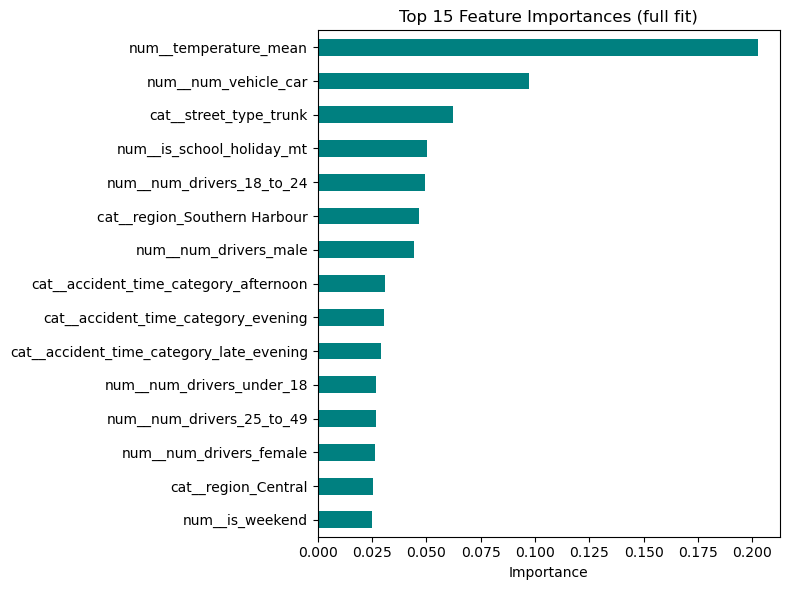

,importance
num__temperature_mean,0.202602
num__num_vehicle_car,0.097138
cat__street_type_trunk,0.062297
num__is_school_holiday_mt,0.050206
num__num_drivers_18_to_24,0.049205
cat__region_Southern Harbour,0.046621
num__num_drivers_male,0.044237
cat__accident_time_category_afternoon,0.030799
cat__accident_time_category_evening,0.030352
cat__accident_time_category_late_evening,0.029124


In [125]:
# Feature importance (top 15) using a fresh fit (clone of clf)
clf_fi = clone(clf)
clf_fi.fit(X, y)

feature_names = clf_fi.named_steps["preprocess"].get_feature_names_out()
importances = pd.Series(clf_fi.named_steps["rf"].feature_importances_, index=feature_names)

top_n = 15
top = importances.sort_values(ascending=False).head(top_n)

fig, ax = plt.subplots(figsize=(8, 6))
top[::-1].plot.barh(ax=ax, color="teal")
ax.set_title(f"Top {top_n} Feature Importances (full fit)")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

top.to_frame("importance")

## 4. Model Evaluation 

### 5.1 Stratified K-Fold cross-validation

In [126]:
print("Running 5-fold cross-validation...\n")

scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

cv_results = cross_validate(
    clf, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Calculate train-test difference in ROC-AUC (overfitting indicator)
train_auc = cv_results["train_roc_auc"].mean()
test_auc  = cv_results["test_roc_auc"].mean()
train_test_diff = abs(train_auc - test_auc)

print("=== Cross-Validation Results (5 folds) ===")
print(f"ROC-AUC:   {test_auc:.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"Accuracy:  {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1-Score:  {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

print("\n=== Overfitting Check ===")
print(f"Train ROC-AUC: {train_auc:.4f} ± {cv_results['train_roc_auc'].std():.4f}")
print(f"Test  ROC-AUC: {test_auc:.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"Train-Test AUC Difference: {train_test_diff:.4f}")

if train_test_diff > 0.05:
    print("Possible overfitting detected (train-test gap > 0.05)")
else:
    print("Model generalizes well (train-test gap <= 0.05)")


Running 5-fold cross-validation...

=== Cross-Validation Results (5 folds) ===
ROC-AUC:   0.8867 ± 0.0785
Accuracy:  0.8911 ± 0.0179
Precision: 0.8000 ± 0.4000
Recall:    0.1800 ± 0.1067
F1-Score:  0.2905 ± 0.1625

=== Overfitting Check ===
Train ROC-AUC: 1.0000 ± 0.0000
Test  ROC-AUC: 0.8867 ± 0.0785
Train-Test AUC Difference: 0.1133
Possible overfitting detected (train-test gap > 0.05)


### 4.1a Tuning the RF

Borrowing the SVM sweep idea, run a randomized search over RF depth, leaf sizes, feature fraction, and class weights to reduce overfitting and improve ROC-AUC/accuracy.


In [127]:
# Randomized search for RF hyperparameters (ROC-AUC focus)

# Parameter space mirrors SVM's C sweep idea but for RF knobs

param_dist = {
    "rf__n_estimators": [200, 300, 500],
    "rf__max_depth": [None, 6, 10, 14, 20],
    "rf__min_samples_split": [2, 5, 10, 20, 30],
    "rf__min_samples_leaf": [1, 2, 4, 8, 12],
    "rf__max_features": ["sqrt", "log2", 0.3, 0.5],
    "rf__max_samples": [0.6, 0.8, 1.0],
    "rf__class_weight": [
        {0: 1, 1: 2},
        {0: 1, 1: 3},
        {0: 1, 1: 4},
        "balanced"
    ],
}

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,

)
search.fit(X, y)

print("Best ROC-AUC (cv): {:.4f}".format(search.best_score_))

print("Best params:\n", search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best ROC-AUC (cv): 0.8962
Best params:
 {'rf__n_estimators': 300, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_samples': 1.0, 'rf__max_features': 0.5, 'rf__max_depth': 20, 'rf__class_weight': {0: 1, 1: 2}}


### 5.3 Baseline comparison

In [128]:
# Compare against a naive baseline (always predict majority class)
print("Running baseline comparison...\n")

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_scores = cross_val_score(dummy, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

print("=== Baseline (Dummy Classifier) ===")
print(f"Dummy ROC-AUC: {dummy_scores.mean():.4f} ± {dummy_scores.std():.4f}")
print(f"\n=== Improvement Over Baseline ===")
print(f"Random Forest ROC-AUC: {test_auc:.4f}")
print(f"Improvement: {(test_auc - dummy_scores.mean()):.4f} ({(test_auc - dummy_scores.mean())/dummy_scores.mean()*100:.1f}% better)")

Running baseline comparison...

=== Baseline (Dummy Classifier) ===
Dummy ROC-AUC: 0.5000 ± 0.0000

=== Improvement Over Baseline ===
Random Forest ROC-AUC: 0.8867
Improvement: 0.3867 (77.3% better)


### 4.2 Train/Validation Split (Visual Diagnostics)

We train a single hold-out model (80/20 stratified split) to surface diagnostics: confusion matrix, ROC curves, and feature importances.

In [129]:
# 1. Setup Model
# Ensure we aren't modifying the original clf object
model_for_val = clone(clf) 

# 2. Split Data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3. Fit and Predict
model_for_val.fit(X_train, y_train)
y_val_proba = model_for_val.predict_proba(X_val)[:, 1]

# 4. Apply Custom Threshold
FIXED_THRESHOLD = 0.3
y_val_pred_thresh = (y_val_proba >= FIXED_THRESHOLD).astype(int)

# 5. Comprehensive Output
metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_thresh),
    "Precision": precision_score(y_val, y_val_pred_thresh, zero_division=0),
    "Recall": recall_score(y_val, y_val_pred_thresh, zero_division=0),
    "F1": f1_score(y_val, y_val_pred_thresh, zero_division=0),
    "ROC-AUC": roc_auc_score(y_val, y_val_proba)
}

print(f"--- Results at Threshold {FIXED_THRESHOLD} ---")
for name, value in metrics.items():
    print(f"{name:10}: {value:.3f}")

# Highly recommended for custom thresholds
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_thresh))

--- Results at Threshold 0.3 ---
Accuracy  : 0.907
Precision : 0.625
Recall    : 0.833
F1        : 0.714
ROC-AUC   : 0.968

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.62      0.83      0.71         6

    accuracy                           0.91        43
   macro avg       0.80      0.88      0.83        43
weighted avg       0.92      0.91      0.91        43



TN: 34, FP: 1, FN: 3, TP: 5


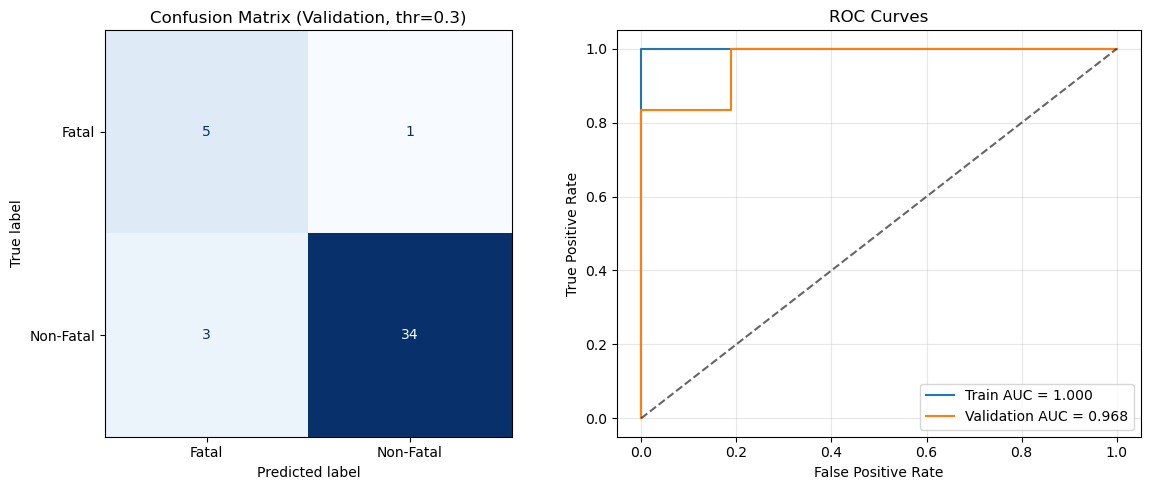

In [130]:
# Visualization: Confusion Matrix and ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
clf_vis = model_for_val

# Define which class is "positive"
LABELS = [1, 0]  # [Fatal, Non-Fatal]

# Confusion matrix at fixed threshold
cm = confusion_matrix(y_val, y_val_pred_thresh, labels=LABELS)  
TP, FP, FN, TN = cm.ravel()
print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")
disp = ConfusionMatrixDisplay(cm, display_labels=["Fatal", "Non-Fatal"])
disp.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title(f"Confusion Matrix (Validation, thr={FIXED_THRESHOLD})")

# ROC curves for train vs validation (threshold-free)
y_train_proba = clf_vis.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
train_auc = roc_auc_score(y_train, y_train_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

axes[1].plot(fpr_train, tpr_train, label=f"Train AUC = {train_auc:.3f}")
axes[1].plot(fpr_val, tpr_val, label=f"Validation AUC = {val_auc:.3f}")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.6)
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curves")
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [131]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
classification_error = (FP + FN) / float(TP + TN + FP + FN)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
specificity = TN / (TN + FP)
f1_score = (2 * precision * recall) / (precision + recall)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
print('Classification error : {0:0.4f}'.format(classification_error))
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('Specificity : {0:0.4f}'.format(specificity))
print('F1 Score : {0:0.4f}'.format(f1_score))

Classification accuracy : 0.9070
Classification error : 0.0930
Precision : 0.8333
Recall or Sensitivity : 0.6250
Specificity : 0.9714
F1 Score : 0.7143
